In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

4867


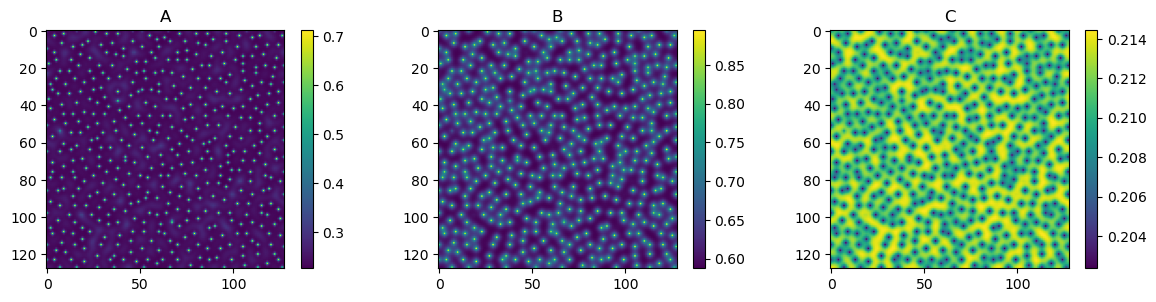

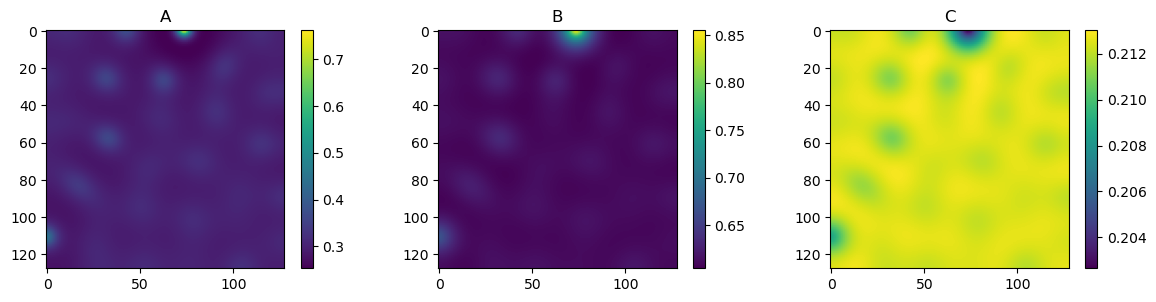

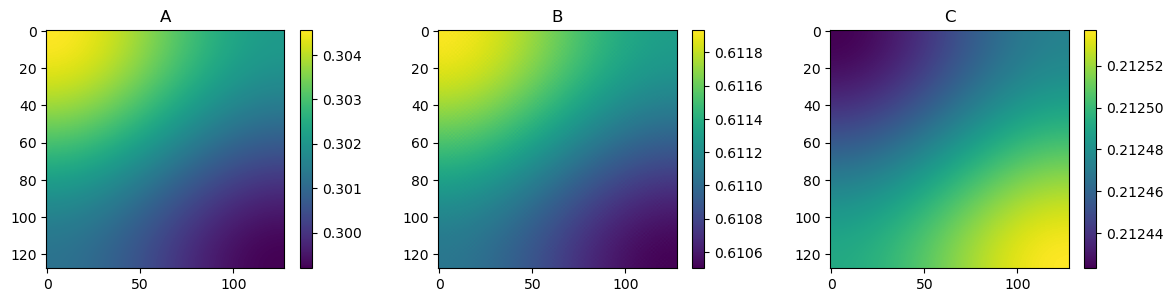

In [5]:
index = 10#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=50
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

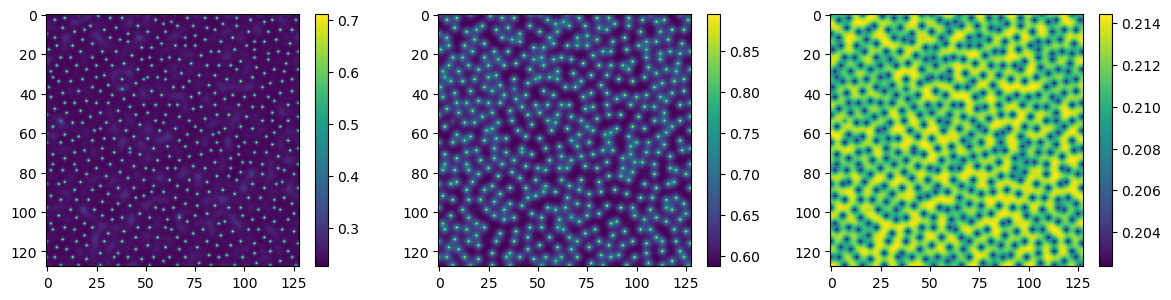

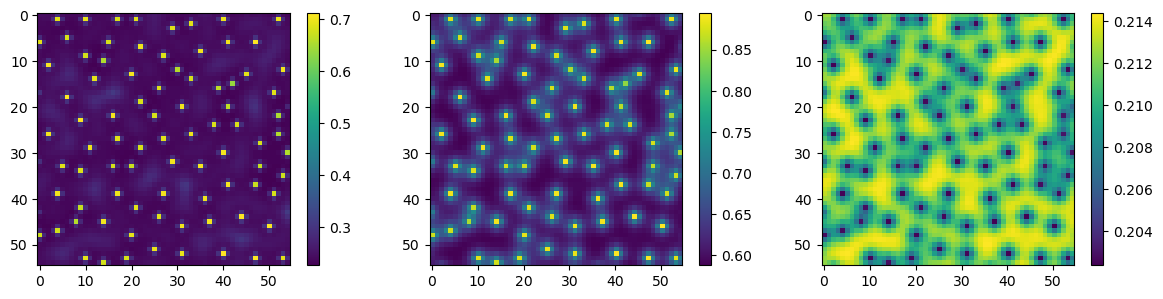

In [7]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [8]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

>
>
>  First
>
<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>
to
<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +    \frac{1}{\frac{1}{V_A} +\left(\frac{\frac{1}{V_A^{1/n}} K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>
<h3><center>$
     = b_A  +    \frac{1}{G_A +\left(\frac{G_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

for 
<h3><center>$
     V_A = \frac{1}{G_A}, K_{AA} = G_{AA}G^{-1/n}_A
$</center></h3>

>
>
> Second
>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

to 

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +    \frac{1}{\frac{1}{V_B}+\left(\frac{\frac{1}{V_B^{1/n}} K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>
<h3><center>$      = b_B  +     \frac{1}{G_B+\left(\frac{G_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

for 
<h3><center>$
     V_B = \frac{1}{G_B}, K_{AB} = G_{AB}G^{-1/n}_B
$</center></h3>

>
>
> Third
>
<h3><center>$
\frac{\partial C}{\partial t} = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>

to 

<h3><center>$
\frac{\partial C}{\partial t} = b_C  +    \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{\frac{1}{V_C}+\left(\frac{\frac{1}{V_C^{1/n}} K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>
<h3><center>$
 = b_C  +    \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{G_C+\left(\frac{G_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>

for

<h3><center>$
     V_C = \frac{1}{G_C}, K_{CC} = G_{CC}G^{-1/n}_C
$</center></h3>

In [9]:
params["G_A"] = 1/params["V_A"]
params["G_AA"] = params["K_AA"]/np.power(params["V_A"], 1/params["n"])
params["G_B"] = 1/params["V_B"]
params["G_AB"] = params["K_AB"]/np.power(params["V_B"], 1/params["n"])
params["G_C"] = 1/params["V_C"]
params["G_CC"] = params["K_CC"]/np.power(params["V_C"], 1/params["n"])

In [10]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 512, 512, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                G_A_val=tf_param("G_A"),G_B_val=tf_param("G_B"),G_C_val=tf_param("G_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                G_AA_val=tf_param("G_AA"),G_AB_val=tf_param("G_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),G_CC_val=tf_param("G_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    G_A = create_tf_var(G_A_val)
    G_B = create_tf_var(G_B_val)
    G_C = create_tf_var(G_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    G_AA = create_tf_var(G_AA_val)
    G_AB = create_tf_var(G_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    G_CC = create_tf_var(G_CC_val)
    n = create_tf_var(n_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(G_A_val, G_A)
                    + as_tuple(G_B_val, G_B)
                    + as_tuple(G_C_val, G_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(G_AA_val, G_AA)
                    + as_tuple(G_AB_val, G_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(G_CC_val, G_CC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(D_A*act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(D_B*act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))
            
            def act2(x, g, gm, n=2):
                return 1 / (g + (gm / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs = D_A * (A_xx + A_yy)# - u_t
            B_rhs = D_B * (B_xx + B_yy)# - v_t
            

            f_A =  b_A + act2(A, G_A, G_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
            f_B =  b_B + act2(A, G_B, G_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
            f_C =  b_C + inh(A, K_AC, n)*inh(B, K_BC, n)*act2(C, G_C, G_CC, n) - mu_C * C
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs)
        
#         if globals()["index"]%1000==0:
#             plot_n_im([to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n)), 
#                        to(V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n))],
#                 ["C", "VC C"],          
#                 figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(A), to(B), to(C)],
#                ["A", "B", "C"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(act(A, K_AA, n)*inh(B, K_BA, n)), to(act(A, K_AB, n)*inh(C, K_CB, n)), to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n))],
#                ["VA", "VB", "VC"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(f_A), to(f_B), to(f_C)],
#                [f"fA {l2_res_A}", f"fB {l2_res_B}", f"fC {l2_res_C:.2f}"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n)), 
#                        to(-b_C+ mu_C * C)],
#                [f"", f""],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(A_rhs),  to(act_A_rhs)],
#               ["RHS A", "Actual RHS A"],          
#               figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(B_rhs),  to(act_B_rhs)],
#                   ["RHS B", "Actual RHS B"],          
#                   figsize=(12, 3)); plt.tight_layout()
#             plt.show()
#         globals()["index"]+=1
        grads = tape.gradient(l2, trainables)
#         if globals()["index"]%100==0:
#             print("="*10)
#             print("="*10)
#             print(grads[-2:])
#             print("="*10)
#             print("="*10)
#         globals()["index"]+=1
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
        printer(f"V_A: {1/G_A.numpy()}, V_B: {1/G_B.numpy()}, V_C: {1/G_C.numpy()}")
        printer(f"K_AA: {G_AA.numpy()*np.power(G_A.numpy(), -1/n.numpy())}")
        printer(f"K_AB: {G_AB.numpy()*np.power(G_B.numpy(), -1/n.numpy())}")
        printer(f"K_CC: {G_CC.numpy()*np.power(G_C.numpy(), -1/n.numpy())}")
        
    
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5)

In [12]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-4,
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 1, False),
G_A_val=tf_param("G_A", 1, False),G_B_val=tf_param("G_B", 1, False),
                                  G_C_val=tf_param("G_C", 1, False),
G_AA_val=tf_param("G_AA", 1, False),
G_AB_val=tf_param("G_AB", 1, False),
K_AC_val=tf_param("K_AC", 1, False), 
#K_BA_val=tf_param("K_BA", 1, False),
#K_BC_val=tf_param("K_BC", 1, False),
#K_CB_val=tf_param("K_CB", 1, False), 
G_CC_val=tf_param("G_CC", 1, False),                                  
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=100, w5=100
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 1
G_A: 1
G_B: 1
G_C: 1
mu_A: 0.5
mu_B: 0.5
mu_C: 5.0
G_AA: 1
G_AB: 1
K_AC: 1
K_BA: 0.5
K_BC: 0.5
K_CB: 100.0
G_CC: 1
n: 4.0


In [13]:
epochs=400000+1
params_est = np.zeros((epochs, len(params_trainable1)))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = [item.numpy() for item in params_trainable1]
#     (b_A.numpy(), b_B.numpy(), b_C.numpy(), 
#                              V_A.numpy(), V_B.numpy(), V_C.numpy(),
#                              mu_A.numpy(), mu_B.numpy(), mu_C.numpy()
#                             )

In [14]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
at epoch 0, total loss: 4985.695933163166
l2_res_A: 2131.35937500, l2_res_B: 1329.32080078, l2_res_C: 8.60962391, l2_res_A_rhs: 0.96741277, l2_res_B_rhs: 1515.43872070
b_A:0: 0.9998999834060669, b_B:0: 0.9998999834060669, b_C:0: 1.000100016593933, G_A:0: 1.000100016593933, G_B:0: 1.000100016593933, G_C:0: 0.9999008774757385, G_AA:0: 1.000100016593933, G_AB:0: 1.000100016593933, K_AC:0: 1.0000998973846436, G_CC:0: 0.9998999834060669
V_A: 0.9998999934083855, V_B: 0.9998999934083855, V_C: 1.0000991323505104
K_AA: 1.0000750115076777
K_AB: 1.0000750115076777
K_CC: 0.9999247630938178
Time taken: 10.97s

Start of epoch 1000
at epoch 1000, total loss: 4077.7963227033615
l2_res_A: 1657.53149414, l2_res_B: 1164.28869629, l2_res_C: 0.45292246, l2_res_A_rhs: 1.06129575, l2_res_B_rhs


Start of epoch 12000
at epoch 12000, total loss: 207.71393739167206
l2_res_A: 7.78285646, l2_res_B: 96.55966187, l2_res_C: 0.00000173, l2_res_A_rhs: 0.13367777, l2_res_B_rhs: 103.23773956
b_A:0: 0.1383008360862732, b_B:0: 0.1378154754638672, b_C:0: 0.9999147057533264, G_A:0: 0.8556579947471619, G_B:0: 0.0007902319775894284, G_C:0: 0.08916977792978287, G_AA:0: 1.3102959394454956, G_AB:0: 0.4794822633266449, K_AC:0: 0.9917269349098206, G_CC:0: 0.3148275911808014
V_A: 1.1686912366143318, V_B: 1265.4511945346235, V_C: 11.214561965013015
K_AA: 1.3623677110776098
K_AB: 2.8597883768783228
K_CC: 0.5761271810254485
Time taken: 26.66s

Start of epoch 13000
at epoch 13000, total loss: 176.03900264159105
l2_res_A: 7.52849674, l2_res_B: 81.83325958, l2_res_C: 0.00000024, l2_res_A_rhs: 0.12267302, l2_res_B_rhs: 86.55457306
b_A:0: 0.13151873648166656, b_B:0: 0.1283291131258011, b_C:0: 0.9998624920845032, G_A:0: 0.6918190717697144, G_B:0: 0.011970696970820427, G_C:0: 0.08710120618343353, G_AA:0: 1.16


Start of epoch 26000
at epoch 26000, total loss: 27.149127393719425
l2_res_A: 0.07069019, l2_res_B: 13.42344093, l2_res_C: 0.00000045, l2_res_A_rhs: 0.07113160, l2_res_B_rhs: 13.58386421
b_A:0: 0.09906550496816635, b_B:0: 0.10242684185504913, b_C:0: 0.9998683929443359, G_A:0: 0.06054053455591202, G_B:0: 0.03948371484875679, G_C:0: 0.07727812975645065, G_AA:0: 0.46710023283958435, G_AB:0: 0.448731005191803, K_AC:0: 1.0087236166000366, G_CC:0: 0.314959853887558
V_A: 16.517858775700983, V_B: 25.32689752801937, V_C: 12.940271758019957
K_AA: 0.9416695363834721
K_AB: 1.0066571361370011
K_CC: 0.5973667553203139
Time taken: 34.21s

Start of epoch 27000
at epoch 27000, total loss: 23.677313306652195
l2_res_A: 0.06952785, l2_res_B: 11.73326683, l2_res_C: 0.00000025, l2_res_A_rhs: 0.06990240, l2_res_B_rhs: 11.80461597
b_A:0: 0.09906292706727982, b_B:0: 0.10229076445102692, b_C:0: 0.99986732006073, G_A:0: 0.06039115786552429, G_B:0: 0.03921521455049515, G_C:0: 0.07671000063419342, G_AA:0: 0.46713


Start of epoch 39000
at epoch 39000, total loss: 6.6468063375788375
l2_res_A: 0.06325854, l2_res_B: 3.25729561, l2_res_C: 0.00000011, l2_res_A_rhs: 0.06359372, l2_res_B_rhs: 3.26265836
b_A:0: 0.09892673790454865, b_B:0: 0.1004103422164917, b_C:0: 0.999873161315918, G_A:0: 0.06040067970752716, G_B:0: 0.04028243198990822, G_C:0: 0.07025711983442307, G_AA:0: 0.4668166935443878, G_AB:0: 0.4473154544830322, K_AC:0: 1.0077840089797974, G_CC:0: 0.31510207056999207
V_A: 16.55610507766156, V_B: 24.824717639950975, V_C: 14.233432887040177
K_AA: 0.9416422182013618
K_AB: 0.9984699122004159
K_CC: 0.6120384004520304
Time taken: 34.10s

Start of epoch 40000
at epoch 40000, total loss: 6.170774161656965
l2_res_A: 0.06290685, l2_res_B: 3.02095914, l2_res_C: 0.00000014, l2_res_A_rhs: 0.06323068, l2_res_B_rhs: 3.02367735
b_A:0: 0.09891575574874878, b_B:0: 0.10039813816547394, b_C:0: 0.9998785853385925, G_A:0: 0.060524214059114456, G_B:0: 0.04020024463534355, G_C:0: 0.06974909454584122, G_AA:0: 0.4667285


Start of epoch 53000
at epoch 53000, total loss: 2.7028538202363848
l2_res_A: 0.05945522, l2_res_B: 1.29207158, l2_res_C: 0.00000007, l2_res_A_rhs: 0.05984450, l2_res_B_rhs: 1.29148245
b_A:0: 0.09868676960468292, b_B:0: 0.10013950616121292, b_C:0: 0.9998889565467834, G_A:0: 0.061890196055173874, G_B:0: 0.0401269756257534, G_C:0: 0.06357789784669876, G_AA:0: 0.4658251106739044, G_AB:0: 0.447252482175827, K_AC:0: 1.0069055557250977, G_CC:0: 0.31522566080093384
V_A: 16.157647959436417, V_B: 24.92089135564461, V_C: 15.728736461391579
K_AA: 0.9339366772551732
K_AB: 0.9992948574746081
K_CC: 0.6277619993015866
Time taken: 30.06s

Start of epoch 54000
at epoch 54000, total loss: 2.835732826481987
l2_res_A: 0.05947992, l2_res_B: 1.35654366, l2_res_C: 0.00000011, l2_res_A_rhs: 0.05992299, l2_res_B_rhs: 1.35978615
b_A:0: 0.09869183599948883, b_B:0: 0.10011108219623566, b_C:0: 0.9998923540115356, G_A:0: 0.06188739836215973, G_B:0: 0.04012807086110115, G_C:0: 0.06313160806894302, G_AA:0: 0.4658118


Start of epoch 66000
at epoch 66000, total loss: 1.72402407844028
l2_res_A: 0.05784345, l2_res_B: 0.80362350, l2_res_C: 0.00000013, l2_res_A_rhs: 0.05827504, l2_res_B_rhs: 0.80428195
b_A:0: 0.09867826104164124, b_B:0: 0.1000390574336052, b_C:0: 0.99990314245224, G_A:0: 0.061957500874996185, G_B:0: 0.0401289239525795, G_C:0: 0.0580914281308651, G_AA:0: 0.4657379686832428, G_AB:0: 0.4471818506717682, K_AC:0: 1.0061864852905273, G_CC:0: 0.3153257668018341
V_A: 16.140095805632534, V_B: 24.91968140440805, V_C: 17.21424368750681
K_AA: 0.9335082743153383
K_AB: 0.999124918053127
K_CC: 0.6422904240912083
Time taken: 29.97s

Start of epoch 67000
at epoch 67000, total loss: 1.8788710823614423
l2_res_A: 0.05806176, l2_res_B: 0.88145119, l2_res_C: 0.00000007, l2_res_A_rhs: 0.05846806, l2_res_B_rhs: 0.88089001
b_A:0: 0.0986744612455368, b_B:0: 0.10003238916397095, b_C:0: 0.9999017119407654, G_A:0: 0.06201630085706711, G_B:0: 0.0401136539876461, G_C:0: 0.05769726634025574, G_AA:0: 0.465704083442688,


Start of epoch 80000
at epoch 80000, total loss: 1.3232944837234015
l2_res_A: 0.05659899, l2_res_B: 0.60499370, l2_res_C: 0.00000006, l2_res_A_rhs: 0.05708706, l2_res_B_rhs: 0.60461468
b_A:0: 0.09859316051006317, b_B:0: 0.10003221780061722, b_C:0: 0.9999117255210876, G_A:0: 0.06256309151649475, G_B:0: 0.04005829617381096, G_C:0: 0.052864883095026016, G_AA:0: 0.4653507471084595, G_AB:0: 0.44722074270248413, K_AC:0: 1.0054999589920044, G_CC:0: 0.31542620062828064
V_A: 15.983864859624946, V_B: 24.963617914777245, V_C: 18.91614889609183
K_AA: 0.9304667648178826
K_AB: 0.9996519562437052
K_CC: 0.6578182920154161
Time taken: 29.91s

Start of epoch 81000
at epoch 81000, total loss: 1.1775731672329641
l2_res_A: 0.05627007, l2_res_B: 0.53212756, l2_res_C: 0.00000007, l2_res_A_rhs: 0.05677629, l2_res_B_rhs: 0.53239918
b_A:0: 0.09858564287424088, b_B:0: 0.10002943873405457, b_C:0: 0.9999141097068787, G_A:0: 0.06261426955461502, G_B:0: 0.040100231766700745, G_C:0: 0.05251490697264671, G_AA:0: 0.46


Start of epoch 93000
at epoch 93000, total loss: 0.6993319250680088
l2_res_A: 0.05416789, l2_res_B: 0.29509175, l2_res_C: 0.00000021, l2_res_A_rhs: 0.05489152, l2_res_B_rhs: 0.29518056
b_A:0: 0.09840115159749985, b_B:0: 0.10005072504281998, b_C:0: 0.9999252557754517, G_A:0: 0.06476852297782898, G_B:0: 0.03998985141515732, G_C:0: 0.04856906458735466, G_AA:0: 0.4640001356601715, G_AB:0: 0.44724205136299133, K_AC:0: 1.0049419403076172, G_CC:0: 0.3155020773410797
V_A: 15.439598651065605, V_B: 25.0063444752128, V_C: 20.589237377661128
K_AA: 0.9197654870203112
K_AB: 1.0001270719958255
K_CC: 0.6720665623338429
Time taken: 29.62s

Start of epoch 94000
at epoch 94000, total loss: 0.7870409057133685
l2_res_A: 0.05422193, l2_res_B: 0.33888167, l2_res_C: 0.00000006, l2_res_A_rhs: 0.05497182, l2_res_B_rhs: 0.33896542
b_A:0: 0.09839572757482529, b_B:0: 0.10005399584770203, b_C:0: 0.9999221563339233, G_A:0: 0.064957395195961, G_B:0: 0.03998290002346039, G_C:0: 0.04826220124959946, G_AA:0: 0.46387761


Start of epoch 106000
at epoch 106000, total loss: 1.1337455735315558
l2_res_A: 0.05238399, l2_res_B: 0.51363939, l2_res_C: 0.00000016, l2_res_A_rhs: 0.05318982, l2_res_B_rhs: 0.51453221
b_A:0: 0.09836083650588989, b_B:0: 0.1000322476029396, b_C:0: 0.999932587146759, G_A:0: 0.0654914602637291, G_B:0: 0.0400497131049633, G_C:0: 0.04475098103284836, G_AA:0: 0.4635475277900696, G_AB:0: 0.4472113251686096, K_AC:0: 1.0044419765472412, G_CC:0: 0.3155739903450012
V_A: 15.269166330588394, V_B: 24.96896787697766, V_C: 22.34587883706895
K_AA: 0.9163219726610801
K_AB: 0.9996844591770844
K_CC: 0.6861207620556374
Time taken: 31.43s

Start of epoch 107000
at epoch 107000, total loss: 1.2680803766797908
l2_res_A: 0.05239422, l2_res_B: 0.58083242, l2_res_C: 0.00000007, l2_res_A_rhs: 0.05323578, l2_res_B_rhs: 0.58161789
b_A:0: 0.09837858378887177, b_B:0: 0.10007710009813309, b_C:0: 0.9999309778213501, G_A:0: 0.06544513255357742, G_B:0: 0.039977919310331345, G_C:0: 0.04447885602712631, G_AA:0: 0.463564


Start of epoch 119000
at epoch 119000, total loss: 0.7000192666472742
l2_res_A: 0.05091310, l2_res_B: 0.29893109, l2_res_C: 0.00000012, l2_res_A_rhs: 0.05170465, l2_res_B_rhs: 0.29847032
b_A:0: 0.09839506447315216, b_B:0: 0.10006669908761978, b_C:0: 0.9999366998672485, G_A:0: 0.0652352124452591, G_B:0: 0.03995809331536293, G_C:0: 0.041361089795827866, G_AA:0: 0.463706374168396, G_AB:0: 0.44727009534835815, K_AC:0: 1.0039952993392944, G_CC:0: 0.3156404495239258
V_A: 15.329144529714396, V_B: 25.026219146836116, V_C: 24.17731266115892
K_AA: 0.9175348010749322
K_AB: 1.000388459028188
K_CC: 0.6999139667474085
Time taken: 31.62s

Start of epoch 120000
at epoch 120000, total loss: 0.5737525379297495
l2_res_A: 0.05071258, l2_res_B: 0.23572704, l2_res_C: 0.00000058, l2_res_A_rhs: 0.05149855, l2_res_B_rhs: 0.23581378
b_A:0: 0.09840624779462814, b_B:0: 0.1000460535287857, b_C:0: 0.9999260902404785, G_A:0: 0.06523296982049942, G_B:0: 0.03996911272406578, G_C:0: 0.04112626984715462, G_AA:0: 0.4636


Start of epoch 132000
at epoch 132000, total loss: 0.8600954927990898
l2_res_A: 0.04897793, l2_res_B: 0.38056588, l2_res_C: 0.00000005, l2_res_A_rhs: 0.04983617, l2_res_B_rhs: 0.38071546
b_A:0: 0.09816314280033112, b_B:0: 0.10005777329206467, b_C:0: 0.9999414682388306, G_A:0: 0.06625388562679291, G_B:0: 0.03997030854225159, G_C:0: 0.038353390991687775, G_AA:0: 0.46307963132858276, G_AB:0: 0.44725754857063293, K_AC:0: 1.003603458404541, G_CC:0: 0.3156982660293579
V_A: 15.093454376894726, V_B: 25.01857094605426, V_C: 26.073313835971565
K_AA: 0.9127520992258948
K_AB: 1.0002839580516163
K_CC: 0.7133805339896182
Time taken: 30.61s

Start of epoch 133000
at epoch 133000, total loss: 0.6103321481805892
l2_res_A: 0.04915347, l2_res_B: 0.25557917, l2_res_C: 0.00000020, l2_res_A_rhs: 0.04999390, l2_res_B_rhs: 0.25560540
b_A:0: 0.09817654639482498, b_B:0: 0.1000717431306839, b_C:0: 0.9999369382858276, G_A:0: 0.06623151153326035, G_B:0: 0.03993815556168556, G_C:0: 0.03814138099551201, G_AA:0: 0.4


Start of epoch 145000
at epoch 145000, total loss: 0.7590197401934802
l2_res_A: 0.04823947, l2_res_B: 0.33092451, l2_res_C: 0.00000006, l2_res_A_rhs: 0.04909162, l2_res_B_rhs: 0.33076409
b_A:0: 0.09819578379392624, b_B:0: 0.10006177425384521, b_C:0: 0.9999485611915588, G_A:0: 0.06630583852529526, G_B:0: 0.039971206337213516, G_C:0: 0.03567349910736084, G_AA:0: 0.4630180597305298, G_AB:0: 0.4472452700138092, K_AC:0: 1.0032562017440796, G_CC:0: 0.3157466948032379
V_A: 15.08162813774697, V_B: 25.018009002870446, V_C: 28.032013259771897
K_AA: 0.912451916739789
K_AB: 1.0002508805183132
K_CC: 0.7265280487773872
Time taken: 28.33s

Start of epoch 146000
at epoch 146000, total loss: 0.7506053287194447
l2_res_A: 0.04797220, l2_res_B: 0.32685649, l2_res_C: 0.00000005, l2_res_A_rhs: 0.04880544, l2_res_B_rhs: 0.32697114
b_A:0: 0.0982007086277008, b_B:0: 0.10004723817110062, b_C:0: 0.9999479055404663, G_A:0: 0.06627118587493896, G_B:0: 0.03995386138558388, G_C:0: 0.0354817770421505, G_AA:0: 0.4630


Start of epoch 158000
at epoch 158000, total loss: 0.46403947010429647
l2_res_A: 0.04670751, l2_res_B: 0.18484204, l2_res_C: 0.00000006, l2_res_A_rhs: 0.04764972, l2_res_B_rhs: 0.18484014
b_A:0: 0.0981074795126915, b_B:0: 0.1000496968626976, b_C:0: 0.999950647354126, G_A:0: 0.06695711612701416, G_B:0: 0.039966654032468796, G_C:0: 0.03329787403345108, G_AA:0: 0.46262070536613464, G_AB:0: 0.44724875688552856, K_AC:0: 1.0029443502426147, G_CC:0: 0.3157939612865448
V_A: 14.934932354360246, V_B: 25.020858618477366, V_C: 30.031947354819078
K_AA: 0.9094438311050265
K_AB: 1.0002871605971377
K_CC: 0.7392642326727069
Time taken: 30.45s

Start of epoch 159000
at epoch 159000, total loss: 0.5111092684035583
l2_res_A: 0.04696807, l2_res_B: 0.20841496, l2_res_C: 0.00000014, l2_res_A_rhs: 0.04788567, l2_res_B_rhs: 0.20784043
b_A:0: 0.0980922132730484, b_B:0: 0.10003248602151871, b_C:0: 0.9999470710754395, G_A:0: 0.06700935959815979, G_B:0: 0.039990417659282684, G_C:0: 0.03312910720705986, G_AA:0: 0.


Start of epoch 171000
at epoch 171000, total loss: 0.3789439507779093
l2_res_A: 0.04619133, l2_res_B: 0.14279521, l2_res_C: 0.00000014, l2_res_A_rhs: 0.04717819, l2_res_B_rhs: 0.14277908
b_A:0: 0.09804712235927582, b_B:0: 0.10005051642656326, b_C:0: 0.9999579191207886, G_A:0: 0.06731179356575012, G_B:0: 0.03995055705308914, G_C:0: 0.031177697703242302, G_AA:0: 0.46239885687828064, G_AB:0: 0.44726255536079407, K_AC:0: 1.0026724338531494, G_CC:0: 0.3158307671546936
V_A: 14.856237622359602, V_B: 25.03094008604508, V_C: 32.07420924784981
K_AA: 0.9078079069044258
K_AB: 1.0004187688044353
K_CC: 0.7516115144918238
Time taken: 29.17s

Start of epoch 172000
at epoch 172000, total loss: 0.5375639087309452
l2_res_A: 0.04639187, l2_res_B: 0.22205569, l2_res_C: 0.00000005, l2_res_A_rhs: 0.04734415, l2_res_B_rhs: 0.22177215
b_A:0: 0.09803841263055801, b_B:0: 0.10002286732196808, b_C:0: 0.9999557733535767, G_A:0: 0.06733183562755585, G_B:0: 0.03997309133410454, G_C:0: 0.03102724812924862, G_AA:0: 0.


Start of epoch 184000
at epoch 184000, total loss: 0.4893788892281634
l2_res_A: 0.04568415, l2_res_B: 0.19857439, l2_res_C: 0.00000006, l2_res_A_rhs: 0.04664220, l2_res_B_rhs: 0.19847809
b_A:0: 0.09797400236129761, b_B:0: 0.10004734992980957, b_C:0: 0.9999616742134094, G_A:0: 0.06763581186532974, G_B:0: 0.03997182101011276, G_C:0: 0.029299326241016388, G_AA:0: 0.46220532059669495, G_AB:0: 0.4472505450248718, K_AC:0: 1.002428650856018, G_CC:0: 0.31586578488349915
V_A: 14.785066851730985, V_B: 25.017624284542922, V_C: 34.13047766948617
K_AA: 0.9063391991333558
K_AB: 1.0002588324793398
K_CC: 0.7634633199938414
Time taken: 28.03s

Start of epoch 185000
at epoch 185000, total loss: 0.43133738121508713
l2_res_A: 0.04571354, l2_res_B: 0.16954848, l2_res_C: 0.00000011, l2_res_A_rhs: 0.04673973, l2_res_B_rhs: 0.16933553
b_A:0: 0.0979650467634201, b_B:0: 0.1000383198261261, b_C:0: 0.9999567866325378, G_A:0: 0.06765662133693695, G_B:0: 0.03998877853155136, G_C:0: 0.029168779030442238, G_AA:0: 0.


Start of epoch 197000
at epoch 197000, total loss: 0.5940912940260716
l2_res_A: 0.04466745, l2_res_B: 0.25196290, l2_res_C: 0.00000005, l2_res_A_rhs: 0.04569052, l2_res_B_rhs: 0.25177038
b_A:0: 0.09788427501916885, b_B:0: 0.10007710754871368, b_C:0: 0.9999629855155945, G_A:0: 0.06817305088043213, G_B:0: 0.039910655468702316, G_C:0: 0.027630126103758812, G_AA:0: 0.4618417024612427, G_AB:0: 0.44729170203208923, K_AC:0: 1.0022099018096924, G_CC:0: 0.31589919328689575
V_A: 14.668552853148492, V_B: 25.05596533698109, V_C: 36.192379153273556
K_AA: 0.9038366816279376
K_AB: 1.000733933342236
K_CC: 0.7748235283869628
Time taken: 30.77s

Start of epoch 198000
at epoch 198000, total loss: 0.49390943125176534
l2_res_A: 0.04443900, l2_res_B: 0.20208843, l2_res_C: 0.00000005, l2_res_A_rhs: 0.04550705, l2_res_B_rhs: 0.20187490
b_A:0: 0.09786790609359741, b_B:0: 0.10006800293922424, b_C:0: 0.9999630451202393, G_A:0: 0.0682486817240715, G_B:0: 0.03990738466382027, G_C:0: 0.02750951610505581, G_AA:0: 0


Start of epoch 210000
at epoch 210000, total loss: 0.7174095500267725
l2_res_A: 0.04405131, l2_res_B: 0.31412891, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04516479, l2_res_B_rhs: 0.31406450
b_A:0: 0.09786494821310043, b_B:0: 0.10006570816040039, b_C:0: 0.9999672174453735, G_A:0: 0.06825459748506546, G_B:0: 0.03995440900325775, G_C:0: 0.026145534589886665, G_AA:0: 0.4617825150489807, G_AB:0: 0.44726017117500305, K_AC:0: 1.0020183324813843, G_CC:0: 0.315925657749176
V_A: 14.651027723353089, V_B: 25.028526887194435, V_C: 38.24744896923275
K_AA: 0.9034508010284883
K_AB: 1.0003893229581515
K_CC: 0.7856615814256348
Time taken: 29.55s

Start of epoch 211000
at epoch 211000, total loss: 0.5539808258806858
l2_res_A: 0.04369138, l2_res_B: 0.23259065, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04477453, l2_res_B_rhs: 0.23292422
b_A:0: 0.09785463660955429, b_B:0: 0.1000531017780304, b_C:0: 0.9999673962593079, G_A:0: 0.06828981637954712, G_B:0: 0.03995748609304428, G_C:0: 0.026039760559797287, G_AA:0: 0.4


Start of epoch 223000
at epoch 223000, total loss: 0.7299191323775176
l2_res_A: 0.04346531, l2_res_B: 0.32091063, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04461124, l2_res_B_rhs: 0.32093191
b_A:0: 0.0978606715798378, b_B:0: 0.10004252195358276, b_C:0: 0.9999692440032959, G_A:0: 0.06837087124586105, G_B:0: 0.03997637704014778, G_C:0: 0.02482485957443714, G_AA:0: 0.461697518825531, G_AB:0: 0.4472484290599823, K_AC:0: 1.0018470287322998, G_CC:0: 0.31595101952552795
V_A: 14.626111701926524, V_B: 25.01477307450128, V_C: 40.2822016777782
K_AA: 0.9029002268057478
K_AB: 1.0002255997320755
K_CC: 0.7959724952114118
Time taken: 29.77s

Start of epoch 224000
at epoch 224000, total loss: 0.4742497660427034
l2_res_A: 0.04335999, l2_res_B: 0.19325854, l2_res_C: 0.00000024, l2_res_A_rhs: 0.04445050, l2_res_B_rhs: 0.19318050
b_A:0: 0.09786159545183182, b_B:0: 0.10003840178251266, b_C:0: 0.9999665021896362, G_A:0: 0.06835595518350601, G_B:0: 0.03998144343495369, G_C:0: 0.024732191115617752, G_AA:0: 0.4617


Start of epoch 236000
at epoch 236000, total loss: 0.4632563619986172
l2_res_A: 0.04315664, l2_res_B: 0.18802090, l2_res_C: 0.00000027, l2_res_A_rhs: 0.04423103, l2_res_B_rhs: 0.18784752
b_A:0: 0.09786897897720337, b_B:0: 0.10004250705242157, b_C:0: 0.9999780654907227, G_A:0: 0.06829249113798141, G_B:0: 0.03999362140893936, G_C:0: 0.02364310808479786, G_AA:0: 0.4617721140384674, G_AB:0: 0.44723451137542725, K_AC:0: 1.0017015933990479, G_CC:0: 0.31596657633781433
V_A: 14.642898265045746, V_B: 25.003987255239664, V_C: 42.29562358778811
K_AA: 0.9033051036976537
K_AB: 1.000086641351947
K_CC: 0.8057772517870884
Time taken: 30.57s

Start of epoch 237000
at epoch 237000, total loss: 0.2940374873994358
l2_res_A: 0.04304541, l2_res_B: 0.10343359, l2_res_C: 0.00000007, l2_res_A_rhs: 0.04415635, l2_res_B_rhs: 0.10340206
b_A:0: 0.09789078682661057, b_B:0: 0.10002107918262482, b_C:0: 0.9999743103981018, G_A:0: 0.06824389845132828, G_B:0: 0.039978452026844025, G_C:0: 0.02356203831732273, G_AA:0: 0.


Start of epoch 249000
at epoch 249000, total loss: 0.35927665210145676
l2_res_A: 0.04261898, l2_res_B: 0.13663757, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04367824, l2_res_B_rhs: 0.13634183
b_A:0: 0.09790552407503128, b_B:0: 0.10004614293575287, b_C:0: 0.9999738931655884, G_A:0: 0.0681629627943039, G_B:0: 0.039969392120838165, G_C:0: 0.022602802142500877, G_AA:0: 0.4618247449398041, G_AB:0: 0.4472472071647644, K_AC:0: 1.0015592575073242, G_CC:0: 0.3159923255443573
V_A: 14.670723792005797, V_B: 25.01914457384622, V_C: 44.24230206924934
K_AA: 0.9038369340668735
K_AB: 1.0002665631376884
K_CC: 0.8149593828343306
Time taken: 30.84s

Start of epoch 250000
at epoch 250000, total loss: 0.32013177212506605
l2_res_A: 0.04252398, l2_res_B: 0.11704144, l2_res_C: 0.00000009, l2_res_A_rhs: 0.04363483, l2_res_B_rhs: 0.11693143
b_A:0: 0.09789544343948364, b_B:0: 0.10004681348800659, b_C:0: 0.9999718070030212, G_A:0: 0.06824588030576706, G_B:0: 0.03995388001203537, G_C:0: 0.02252948097884655, G_AA:0: 0.


Start of epoch 262000
at epoch 262000, total loss: 0.7021897113682201
l2_res_A: 0.04220671, l2_res_B: 0.30854443, l2_res_C: 0.00000006, l2_res_A_rhs: 0.04325318, l2_res_B_rhs: 0.30818534
b_A:0: 0.0979062169790268, b_B:0: 0.10003143548965454, b_C:0: 0.9999744296073914, G_A:0: 0.0682653933763504, G_B:0: 0.039978351444005966, G_C:0: 0.02167128585278988, G_AA:0: 0.46177902817726135, G_AB:0: 0.44723790884017944, K_AC:0: 1.001437783241272, G_CC:0: 0.3160111904144287
V_A: 14.648710723557276, V_B: 25.01353767427376, V_C: 46.144008564737
K_AA: 0.9034082580593163
K_AB: 1.0001897229010557
K_CC: 0.8236283589535641
Time taken: 29.76s

Start of epoch 263000
at epoch 263000, total loss: 0.5556205394797473
l2_res_A: 0.04190481, l2_res_B: 0.23528904, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04303769, l2_res_B_rhs: 0.23538896
b_A:0: 0.09789768606424332, b_B:0: 0.10005048662424088, b_C:0: 0.9999759197235107, G_A:0: 0.06828075647354126, G_B:0: 0.03997104987502098, G_C:0: 0.021603111177682877, G_AA:0: 0.4617


Start of epoch 275000
at epoch 275000, total loss: 0.3673588274256474
l2_res_A: 0.04190959, l2_res_B: 0.14124702, l2_res_C: 0.00000006, l2_res_A_rhs: 0.04298038, l2_res_B_rhs: 0.14122178
b_A:0: 0.0978962630033493, b_B:0: 0.10005965828895569, b_C:0: 0.99997878074646, G_A:0: 0.06822327524423599, G_B:0: 0.03994220867753029, G_C:0: 0.020842798054218292, G_AA:0: 0.46182724833488464, G_AB:0: 0.4472654163837433, K_AC:0: 1.0013318061828613, G_CC:0: 0.31602394580841064
V_A: 14.657754211008616, V_B: 25.036171837000982, V_C: 47.978203185517785
K_AA: 0.9036420079736195
K_AB: 1.0004774391854205
K_CC: 0.8317273563801768
Time taken: 30.52s

Start of epoch 276000
at epoch 276000, total loss: 0.5163150476469838
l2_res_A: 0.04166332, l2_res_B: 0.21591198, l2_res_C: 0.00000009, l2_res_A_rhs: 0.04276571, l2_res_B_rhs: 0.21597394
b_A:0: 0.0978977158665657, b_B:0: 0.1000516414642334, b_C:0: 0.9999784231185913, G_A:0: 0.0683080404996872, G_B:0: 0.03996528685092926, G_C:0: 0.020782940089702606, G_AA:0: 0.461


Start of epoch 288000
at epoch 288000, total loss: 0.7819768586602578
l2_res_A: 0.04178641, l2_res_B: 0.34886456, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04285704, l2_res_B_rhs: 0.34846881
b_A:0: 0.09789502620697021, b_B:0: 0.10004078596830368, b_C:0: 0.9999780654907227, G_A:0: 0.06833957135677338, G_B:0: 0.039952732622623444, G_C:0: 0.020107246935367584, G_AA:0: 0.4617122709751129, G_AB:0: 0.44726333022117615, K_AC:0: 1.001235008239746, G_CC:0: 0.3160398602485657
V_A: 14.632810539290666, V_B: 25.029577061613672, V_C: 49.733312731195085
K_AA: 0.9030324450892318
K_AB: 1.000406882581854
K_CC: 0.8392738820472162
Time taken: 30.79s

Start of epoch 289000
at epoch 289000, total loss: 0.40183635727795775
l2_res_A: 0.04140946, l2_res_B: 0.15910891, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04249291, l2_res_B_rhs: 0.15882504
b_A:0: 0.09787865728139877, b_B:0: 0.10004720091819763, b_C:0: 0.9999791979789734, G_A:0: 0.06840460002422333, G_B:0: 0.03996336832642555, G_C:0: 0.0200531966984272, G_AA:0: 0.


Start of epoch 301000
at epoch 301000, total loss: 0.3819420319273519
l2_res_A: 0.04095585, l2_res_B: 0.14950317, l2_res_C: 0.00000014, l2_res_A_rhs: 0.04204417, l2_res_B_rhs: 0.14943871
b_A:0: 0.09787450730800629, b_B:0: 0.10003415495157242, b_C:0: 0.9999768137931824, G_A:0: 0.06841450929641724, G_B:0: 0.03997156023979187, G_C:0: 0.01945512369275093, G_AA:0: 0.4617024064064026, G_AB:0: 0.4472508132457733, K_AC:0: 1.0011471509933472, G_CC:0: 0.31605467200279236
V_A: 14.616782467405178, V_B: 25.017787496933767, V_C: 51.40034141096747
K_AA: 0.9027657707795721
K_AB: 1.0002610637384386
K_CC: 0.8462598087133528
Time taken: 30.76s

Start of epoch 302000
at epoch 302000, total loss: 0.5264182492083336
l2_res_A: 0.04110493, l2_res_B: 0.22185075, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04216869, l2_res_B_rhs: 0.22129384
b_A:0: 0.09786350280046463, b_B:0: 0.10002556443214417, b_C:0: 0.9999803304672241, G_A:0: 0.06841067224740982, G_B:0: 0.03999629244208336, G_C:0: 0.01940475031733513, G_AA:0: 0.4


Start of epoch 314000
at epoch 314000, total loss: 0.4963137393000636
l2_res_A: 0.04073184, l2_res_B: 0.20700355, l2_res_C: 0.00000006, l2_res_A_rhs: 0.04184361, l2_res_B_rhs: 0.20673469
b_A:0: 0.09787819534540176, b_B:0: 0.10005532205104828, b_C:0: 0.9999822378158569, G_A:0: 0.06851186603307724, G_B:0: 0.039955753833055496, G_C:0: 0.018867915496230125, G_AA:0: 0.4616227149963379, G_AB:0: 0.44725939631462097, K_AC:0: 1.0010757446289062, G_CC:0: 0.3160613179206848
V_A: 14.596011726161484, V_B: 25.0276844776408, V_C: 53.00002537110172
K_AA: 0.9022891226006723
K_AB: 1.0003791719620228
K_CC: 0.8527865970460073
Time taken: 30.63s

Start of epoch 315000
at epoch 315000, total loss: 0.6854541476574951
l2_res_A: 0.04084506, l2_res_B: 0.30150494, l2_res_C: 0.00000008, l2_res_A_rhs: 0.04193342, l2_res_B_rhs: 0.30117065
b_A:0: 0.09785374999046326, b_B:0: 0.10006384551525116, b_C:0: 0.9999791383743286, G_A:0: 0.06856349110603333, G_B:0: 0.03991732373833656, G_C:0: 0.018829314038157463, G_AA:0: 0.


Start of epoch 327000
at epoch 327000, total loss: 0.37749397334268053
l2_res_A: 0.04047455, l2_res_B: 0.14775063, l2_res_C: 0.00000005, l2_res_A_rhs: 0.04159025, l2_res_B_rhs: 0.14767849
b_A:0: 0.09783933311700821, b_B:0: 0.10006497800350189, b_C:0: 0.9999819993972778, G_A:0: 0.06851859390735626, G_B:0: 0.03993872553110123, G_C:0: 0.018350791186094284, G_AA:0: 0.46165990829467773, G_AB:0: 0.4472576379776001, K_AC:0: 1.0010087490081787, G_CC:0: 0.31607234477996826
V_A: 14.594578536624617, V_B: 25.03835529807471, V_C: 54.493563239811266
K_AA: 0.9023396690785909
K_AB: 1.0004818522339425
K_CC: 0.8587619627074523
Time taken: 32.73s

Start of epoch 328000
at epoch 328000, total loss: 0.7920313999832871
l2_res_A: 0.04064497, l2_res_B: 0.35509157, l2_res_C: 0.00000017, l2_res_A_rhs: 0.04170823, l2_res_B_rhs: 0.35458645
b_A:0: 0.09786798059940338, b_B:0: 0.10006073117256165, b_C:0: 0.9999876618385315, G_A:0: 0.06847580522298813, G_B:0: 0.03997311741113663, G_C:0: 0.01830788142979145, G_AA:0: 


Start of epoch 340000
at epoch 340000, total loss: 0.39411107189891936
l2_res_A: 0.04004061, l2_res_B: 0.15641120, l2_res_C: 0.00000008, l2_res_A_rhs: 0.04115349, l2_res_B_rhs: 0.15650569
b_A:0: 0.09791435301303864, b_B:0: 0.10004280507564545, b_C:0: 0.9999858140945435, G_A:0: 0.06823774427175522, G_B:0: 0.03995500132441521, G_C:0: 0.01788835972547531, G_AA:0: 0.46180260181427, G_AB:0: 0.4472615420818329, K_AC:0: 1.0009514093399048, G_CC:0: 0.31607791781425476
V_A: 14.654646203097268, V_B: 25.02815584663571, V_C: 55.902274738799676
K_AA: 0.9035458799748953
K_AB: 1.000388681621679
K_CC: 0.8642741542545839
Time taken: 30.30s

Start of epoch 341000
at epoch 341000, total loss: 0.49767032454366245
l2_res_A: 0.04033863, l2_res_B: 0.20790131, l2_res_C: 0.00000015, l2_res_A_rhs: 0.04146249, l2_res_B_rhs: 0.20796774
b_A:0: 0.09790263324975967, b_B:0: 0.1000383272767067, b_C:0: 0.9999878406524658, G_A:0: 0.06822627037763596, G_B:0: 0.039982542395591736, G_C:0: 0.017853403463959694, G_AA:0: 0.4


Start of epoch 353000
at epoch 353000, total loss: 0.4096573804793735
l2_res_A: 0.04013441, l2_res_B: 0.16429675, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04118979, l2_res_B_rhs: 0.16403639
b_A:0: 0.09790593385696411, b_B:0: 0.100046806037426, b_C:0: 0.999984622001648, G_A:0: 0.06823284178972244, G_B:0: 0.03995794057846069, G_C:0: 0.017480997368693352, G_AA:0: 0.4618074297904968, G_AB:0: 0.44724735617637634, K_AC:0: 1.0008976459503174, G_CC:0: 0.3160876929759979
V_A: 14.655699129193016, V_B: 25.026314808102235, V_C: 57.20497400170633
K_AA: 0.9035715557320296
K_AB: 1.0003385552993422
K_CC: 0.8692927045087909
Time taken: 31.24s

Start of epoch 354000
at epoch 354000, total loss: 0.4509505088682886
l2_res_A: 0.04007725, l2_res_B: 0.18480416, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04117549, l2_res_B_rhs: 0.18489356
b_A:0: 0.09789609909057617, b_B:0: 0.1000484898686409, b_C:0: 0.9999852180480957, G_A:0: 0.0682133212685585, G_B:0: 0.03996771201491356, G_C:0: 0.01745004579424858, G_AA:0: 0.46184


Start of epoch 366000
at epoch 366000, total loss: 0.3026054825744495
l2_res_A: 0.03965452, l2_res_B: 0.11109364, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04074212, l2_res_B_rhs: 0.11111516
b_A:0: 0.09789833426475525, b_B:0: 0.10004308819770813, b_C:0: 0.9999852180480957, G_A:0: 0.06812746822834015, G_B:0: 0.039962928742170334, G_C:0: 0.017116505652666092, G_AA:0: 0.461905837059021, G_AB:0: 0.4472581446170807, K_AC:0: 1.0008509159088135, G_CC:0: 0.31609460711479187
V_A: 14.678367272483097, V_B: 25.023191029159072, V_C: 58.42313964616011
K_AA: 0.9041133623537796
K_AB: 1.0003314676095445
K_CC: 0.8739031594100714
Time taken: 29.60s

Start of epoch 367000
at epoch 367000, total loss: 0.5090519590754354
l2_res_A: 0.03975023, l2_res_B: 0.21447091, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04078771, l2_res_B_rhs: 0.21404307
b_A:0: 0.09791508316993713, b_B:0: 0.10004967451095581, b_C:0: 0.9999851584434509, G_A:0: 0.06811178475618362, G_B:0: 0.03997085243463516, G_C:0: 0.01709016226232052, G_AA:0: 0.


Start of epoch 379000
at epoch 379000, total loss: 0.3715189450300187
l2_res_A: 0.03945564, l2_res_B: 0.14581373, l2_res_C: 0.00000006, l2_res_A_rhs: 0.04048832, l2_res_B_rhs: 0.14576119
b_A:0: 0.0979505106806755, b_B:0: 0.10004876554012299, b_C:0: 0.9999876618385315, G_A:0: 0.06787042319774628, G_B:0: 0.039969854056835175, G_C:0: 0.01679016463458538, G_AA:0: 0.46204274892807007, G_AB:0: 0.4472481608390808, K_AC:0: 1.0008100271224976, G_CC:0: 0.3160988986492157
V_A: 14.733958518078111, V_B: 25.018855424842158, V_C: 59.558677461693286
K_AA: 0.9052364227277306
K_AB: 1.0002658059600815
K_CC: 0.8781308686302339
Time taken: 27.49s

Start of epoch 380000
at epoch 380000, total loss: 0.3339229699699615
l2_res_A: 0.03947315, l2_res_B: 0.12701049, l2_res_C: 0.00000004, l2_res_A_rhs: 0.04047922, l2_res_B_rhs: 0.12696007
b_A:0: 0.0979415699839592, b_B:0: 0.10006044805049896, b_C:0: 0.9999861121177673, G_A:0: 0.0678226500749588, G_B:0: 0.03994446247816086, G_C:0: 0.01676875539124012, G_AA:0: 0.46


Start of epoch 392000
at epoch 392000, total loss: 0.3867800180581753
l2_res_A: 0.03908344, l2_res_B: 0.15377513, l2_res_C: 0.00000005, l2_res_A_rhs: 0.04008564, l2_res_B_rhs: 0.15383577
b_A:0: 0.09797556698322296, b_B:0: 0.1000371128320694, b_C:0: 0.9999875426292419, G_A:0: 0.06756626069545746, G_B:0: 0.03997743874788284, G_C:0: 0.016506023705005646, G_AA:0: 0.46226102113723755, G_AB:0: 0.44725024700164795, K_AC:0: 1.0007729530334473, G_CC:0: 0.3161048889160156
V_A: 14.800286262803809, V_B: 25.014108740344422, V_C: 60.583943042365696
K_AA: 0.906681601766448
K_AB: 1.00022302436445
K_CC: 0.8819025464754687
Time taken: 30.04s

Start of epoch 393000
at epoch 393000, total loss: 0.38470607510261345
l2_res_A: 0.03892405, l2_res_B: 0.15288533, l2_res_C: 0.00000004, l2_res_A_rhs: 0.03993442, l2_res_B_rhs: 0.15296224
b_A:0: 0.09799138456583023, b_B:0: 0.10003741085529327, b_C:0: 0.9999865293502808, G_A:0: 0.06752483546733856, G_B:0: 0.0399743989109993, G_C:0: 0.01648685894906521, G_AA:0: 0.46

In [ ]:
'b_A': 0.1, 'b_B': 0.1, 'b_C': 1.0 
'V_A': 20.0, 'V_B': 25.0, 'V_C': 100.0
'K_AA': 1.0, 
'K_AB': 1.0, 
'K_CC': 1.0

            
'K_AC': 1.0, 'K_BA': 0.5, 'K_BC': 0.5, 'K_CB': 100.0, 

In [54]:
print(params)

{'D_A': 0.01, 'D_B': 1.0, 'n': 4.0, 'b_A': 0.1, 'mu_A': 0.5, 'V_A': 20.0, 'K_AA': 1.0, 'K_AB': 1.0, 'K_AC': 1.0, 'b_B': 0.1, 'mu_B': 0.5, 'V_B': 25.0, 'K_BA': 0.5, 'K_BC': 0.5, 'b_C': 1.0, 'mu_C': 5.0, 'V_C': 100.0, 'K_CB': 100.0, 'K_CC': 1.0}


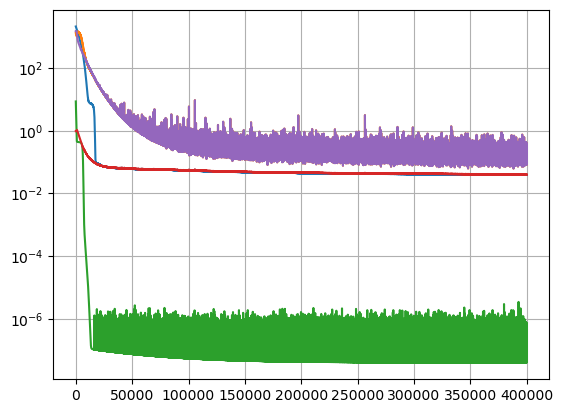

In [16]:
plt.plot(losses1)
plt.yscale('log')
plt.grid()

In [17]:
params_est_1 = params_est.copy()

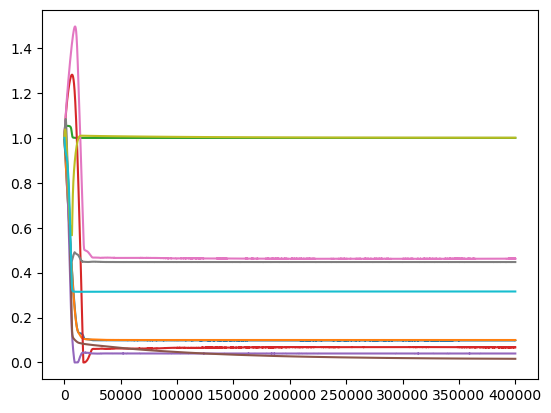

In [18]:
plt.plot(params_est_1); plt.show()

In [19]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = params["D_A"]
D_B = params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [20]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der-actual_A_der)**2))
    print(np.sum((B_der-actual_B_der)**2))


    plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der,  actual_A_der],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der,  actual_B_der],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

1.312285125431119
1345.4825315675612


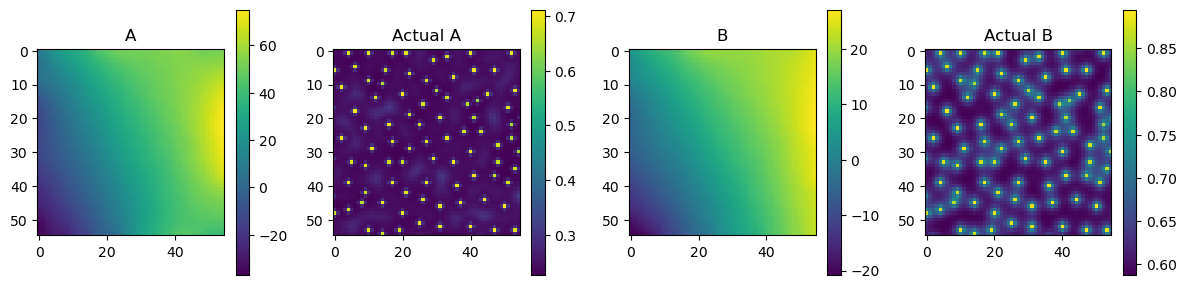

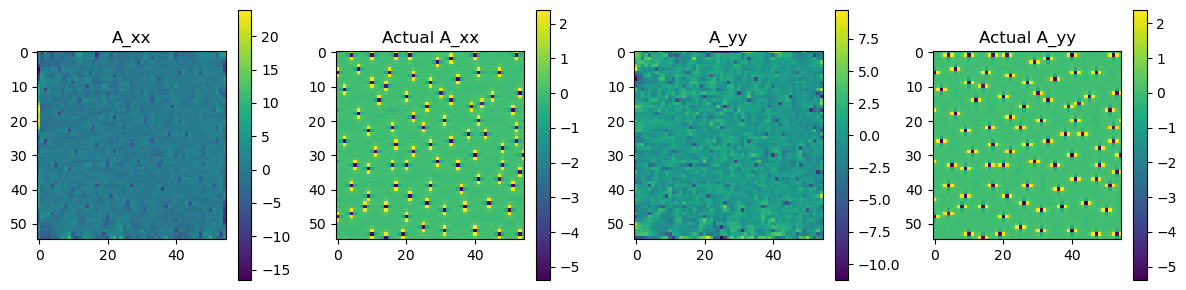

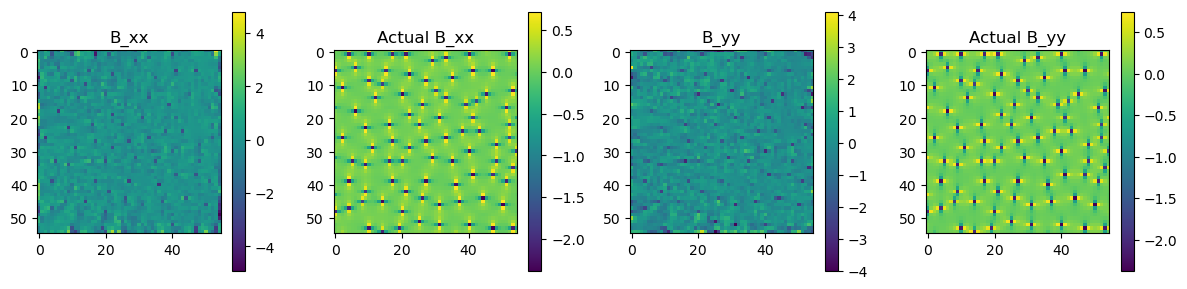

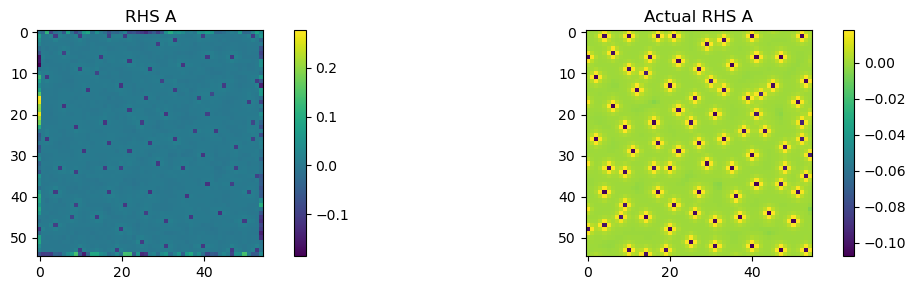

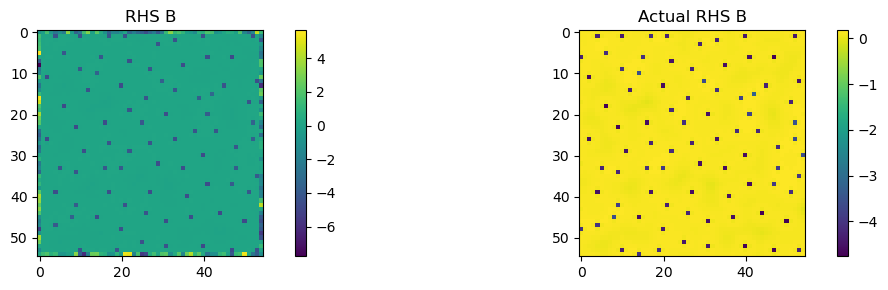

In [21]:
plot_state(pinn1)